# Save datasets to a ROOT file after processing

With RDataFrame, you can read your dataset, add new columns with processed values and finally use `Snapshot` to save the resulting data to a ROOT file in TTree format.

In [1]:
import ROOT

df = ROOT.RDataFrame("dataset","../../data/example_file.root")
df1 = df.Define("c","a+b")

out_treename = "outtree"
out_filename = "outtree.root"
out_columns = ["a","b","c"]

snapdf = df1.Snapshot(out_treename, out_filename, out_columns)

We can now check that the dataset was correctly stored in a file:

In [2]:
%%bash
rootls -lt outtree.root

TTree  Jan 16 14:50 2025 outtree;1 "outtree" 
  a  "a/D"  16071
  b  "b/D"  16071
  c  "c/D"  16071
  Cluster INCLUSIVE ranges:
   - # 0: [0, 1999]
  The total number of clusters is 1


Result of a Snapshot is still an RDataFrame that can be further used:

In [3]:
snapdf.Display().Print()

+-----+-----------+----------+-----------+
| Row | a         | b        | c         | 
+-----+-----------+----------+-----------+
| 0   | 0.977711  | 0.999742 | 1.977453  | 
+-----+-----------+----------+-----------+
| 1   | 2.280201  | 0.484974 | 2.765175  | 
+-----+-----------+----------+-----------+
| 2   | 0.563482  | 0.392314 | 0.955796  | 
+-----+-----------+----------+-----------+
| 3   | 3.042156  | 0.333539 | 3.375695  | 
+-----+-----------+----------+-----------+
| 4   | 28.574399 | 0.648126 | 29.222524 | 
+-----+-----------+----------+-----------+


Further options can be passed as the fourth argument to the `Snapshot` call, through an object of type `RSnapshotOptions`. Different options control different behaviours of the snapshot, see more at https://root.cern/doc/master/structROOT_1_1RDF_1_1RSnapshotOptions.html.

In [4]:
options = ROOT.RDF.RSnapshotOptions()

# Force lazy snapshot: it will not be triggered right away
options.fLazy = True

# Avoid changing input columns of type `std::vector` to `ROOT::RVec` when saving
options.fVector2RVec = False

snapdf_withopts = df1.Snapshot(out_treename, out_filename, out_columns, options)

# Cutflow reports
Filters applied to the dataset can be given a name. The `Report` method will gather information about filter efficiency and show the data flow between subsequent cuts on the original dataset.


In [5]:
df = ROOT.RDataFrame("sig_tree", "https://root.cern/files/Higgs_data.root")

filter1 = df.Filter("lepton_eta > 0", "Lepton eta cut")
filter2 = filter1.Filter("lepton_phi < 1", "Lepton phi cut")

rep = df.Report()
rep.Print()

Lepton eta cut: pass=4880       all=10000      -- eff=48.80 % cumulative eff=48.80 %
Lepton phi cut: pass=3842       all=4880       -- eff=78.73 % cumulative eff=38.42 %


# Using C++ functions in Python
- We still want to perform complex operations in Python but plain Python code is prone to be slow and not thread-safe. 

- Instead, you can inject C++ functions that will do the work in your event loop during runtime. 

- This mechanism uses the C++ interpreter `cling` shipped with ROOT, making this possible in a single line of code. 

- Let's start by defining a function that will allow us to change the type of a the RDataFrame dataset entry numbers (stored in the special column "rdfentry") from `unsigned long long` to `float`.

In [6]:
%%cpp

float asfloat(unsigned long long entrynumber){
    return entrynumber;
}

Then let's define another function that takes a `float` values and computes its square.

In [7]:
%%cpp

float square(float val){
    return val * val;
}

And now let's use these functions with RDataFrame! 

We start by creating an empty RDataFrame with 100 consecutive entries and defining new columns on it:

In [8]:
# Create a new RDataFrame from scratch with 100 consecutive entries
df = ROOT.RDataFrame(100)

# Create a new column using the previously declared C++ functions
df1 = df.Define("a", "asfloat(rdfentry_)")
df2 = df1.Define("b", "square(a)")

We can now plot the values of the columns in a graph:

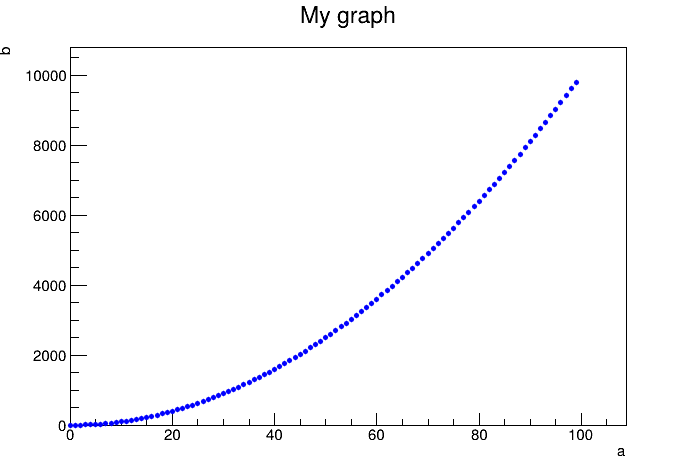

In [9]:
# Show the two columns created in a graph
c = ROOT.TCanvas()
graph = df2.Graph("a","b")
graph.SetMarkerStyle(20)
graph.SetMarkerSize(0.5)
graph.SetMarkerColor(ROOT.kBlue)
graph.SetTitle("My graph")
graph.Draw("AP")
c.Draw()

# Using all cores of your machine with multi-threaded RDataFrame
- RDataFrame can transparently perform multi-threaded event loops to speed up the execution of its actions. 

- Users have to call `ROOT::EnableImplicitMT()` before constructing the RDataFrame object to indicate that it should take advantage of a pool of worker threads. 

- Each worker thread processes a distinct subset of entries, and their partial results are merged before returning the final values to the user.

- RDataFrame operations such as Histo1D or Snapshot are guaranteed to work correctly in multi-thread event loops. 

- User-defined expressions, such as strings or lambdas passed to `Filter`, `Define`, `Foreach`, `Reduce` or `Aggregate` will have to be thread-safe, i.e. it should be possible to call them concurrently from different threads.

In [10]:
%%time
# Get a first baseline measurement

treename = "myDataset"
filename = "../../data/collections_dataset.root"
df = ROOT.RDataFrame(treename, filename)
df1 = df.Define("good_pt", "sqrt(px*px + py*py)[E>100]")

df1.Mean("good_pt").GetValue()

CPU times: user 995 ms, sys: 9.61 ms, total: 1 s
Wall time: 1.01 s


0.4966851343353398

In [11]:
%%time
# Activate multithreading capabilities
# By default takes all available cores on the machine
ROOT.EnableImplicitMT()

treename = "myDataset"
filename = "../../data/collections_dataset.root"
df = ROOT.RDataFrame(treename, filename)
df1 = df.Define("good_pt", "sqrt(px*px + py*py)[E>100]")

df1.Mean("good_pt").GetValue()

# Disable implicit multithreading when done
ROOT.DisableImplicitMT()

CPU times: user 178 ms, sys: 3.69 ms, total: 181 ms
Wall time: 182 ms


# Working with multiple samples in the dataset

Once the analysis starts including more than one sample (e.g. different physics processes, real data vs simulation etc.), RDataFrame allows treating them separately within the computation graph. As a rule of thumb, creating one single RDataFrame taking in all the input data samples needed in the analysis should be aimed for. This results in only one JIT compilation for the entire analysis, and also better scheduling opportunities.

The [`DefinePerSample`](https://root.cern/doc/master/classROOT_1_1RDF_1_1RInterface.html#a29d77593e95c0f84e359a802e6836a0e) method allows working with multiple samples in the dataset. It accepts a function that takes two input parameters, the slot and the sample info, which is evaluated once at the beginning of every new file in the chain. In Python, the two input parameters are available via the magic columns `rdfslot_` and `rdfsampleinfo_`. The latter contains an object of type [`RSampleInfo`](https://root.cern/doc/master/classROOT_1_1RDF_1_1RSampleInfo.html) with all the information available for the current sample being processed.

In [12]:
def create_sample(sample_name):
    ROOT.RDataFrame(5).Define("x", "42").Snapshot("Events", sample_name)

samples = ["sample_A.root", "sample_B.root"]
for sample in samples:
    create_sample(sample)

df = ROOT.RDataFrame("Events", samples)
df = df.DefinePerSample("weight", 'rdfsampleinfo_.Contains("sample_A") ? 11 : 22')

df.Display(["x", "weight"], 10).Print()

+-----+----+--------+
| Row | x  | weight | 
+-----+----+--------+
| 0   | 42 | 11     | 
+-----+----+--------+
| 1   | 42 | 11     | 
+-----+----+--------+
| 2   | 42 | 11     | 
+-----+----+--------+
| 3   | 42 | 11     | 
+-----+----+--------+
| 4   | 42 | 11     | 
+-----+----+--------+
| 5   | 42 | 22     | 
+-----+----+--------+
| 6   | 42 | 22     | 
+-----+----+--------+
| 7   | 42 | 22     | 
+-----+----+--------+
| 8   | 42 | 22     | 
+-----+----+--------+
| 9   | 42 | 22     | 
+-----+----+--------+


# Multiple concurrent RDataFrame runs
If your analysis needs multiple RDataFrames to run (for example multiple dataset samples, data vs simulation etc.), make use of `ROOT.RDF.RunGraphs` 

In [13]:
ROOT.EnableImplicitMT()
treename1 = "myDataset"
filename1 = "../../data/collections_dataset.root"
treename2 = "dataset"
filename2 = "../../data/example_file.root"

df1 = ROOT.RDataFrame(treename1, filename1)
df2 = ROOT.RDataFrame(treename2, filename2)
h1 = df1.Histo1D("px")
h2 = df2.Histo1D("a")


ROOT.RDF.RunGraphs((h1, h2))
ROOT.DisableImplicitMT()

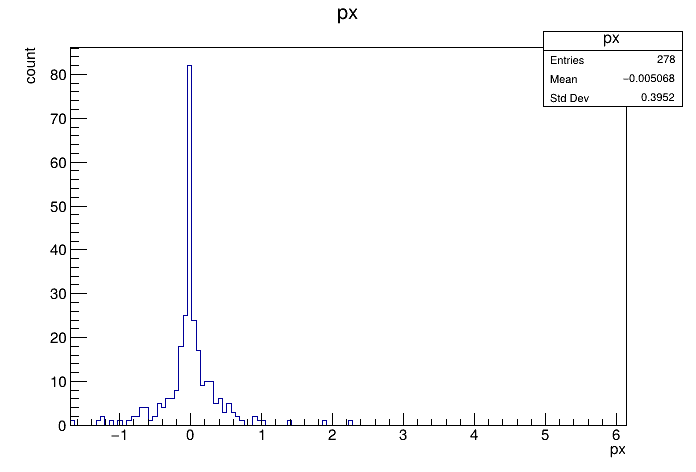

In [14]:
c = ROOT.TCanvas()
h1.Draw()
c.Draw()

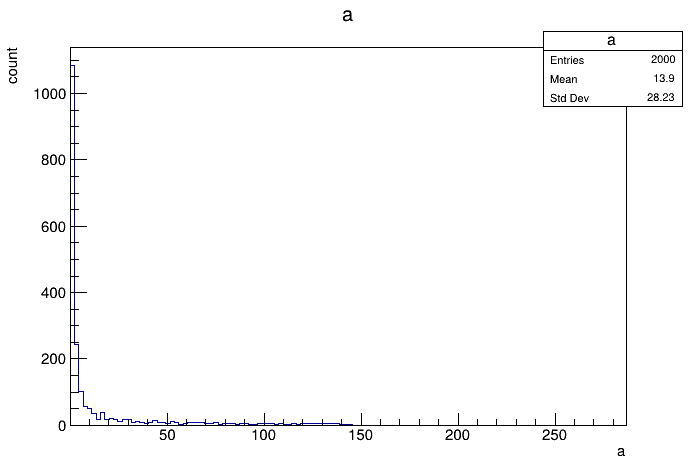

In [15]:
c = ROOT.TCanvas()
h2.Draw()
c.Draw()

# Re-defining values of a column

Sometimes you might want to keep a column with the same name, but modify its values. This is available via the `Redefine` method.

In [16]:
df = ROOT.RDataFrame(5).Define("x", "42")
df.Display().Print()

+-----+----+
| Row | x  | 
+-----+----+
| 0   | 42 | 
+-----+----+
| 1   | 42 | 
+-----+----+
| 2   | 42 | 
+-----+----+
| 3   | 42 | 
+-----+----+
| 4   | 42 | 
+-----+----+


In [17]:
df = df.Redefine("x", "x * 10")
df.Display().Print()

+-----+-----+
| Row | x   | 
+-----+-----+
| 0   | 420 | 
+-----+-----+
| 1   | 420 | 
+-----+-----+
| 2   | 420 | 
+-----+-----+
| 3   | 420 | 
+-----+-----+
| 4   | 420 | 
+-----+-----+


Notice how we could use the previous values of the `"x"` column to define the new values.